<a href="https://colab.research.google.com/github/0011Ashwin/Google-Colab-Work/blob/main/how_to_use_florence_2_for_object_detection_and_video_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

  <a href="https://ultralytics.com/yolo" target="_blank">
    <img width="1024", src="https://raw.githubusercontent.com/ultralytics/assets/main/yolov8/banner-yolov8.png"></a>


  
  This notebook demonstrates how to use Florence 2 with Ultralytics <a href="https://github.com/ultralytics/ultralytics">YOLO</a> annotators for object detection, image segmentation, and generating visualizations from text prompts, such as image captioning. We aim to provide resources that help you maximize the potential of Florence-2. If you need assistance, feel free to raise an issue on <a href="https://github.com/ultralytics/ultralytics">GitHub</a> or join our <a href="https://ultralytics.com/discord">Discord</a> community for discussions and support!

# What is Florence-2?

Microsoft released the Florence-2 model last year, It is an advanced vision foundation model that uses a prompt-based approach to handle a wide range of vision and vision-language tasks. It can interpret simple text prompts to perform tasks like captioning, object detection, and segmentation.
  
It leverages the FLD-5B dataset, containing 5.4 billion annotations across 126 million images, to master multi-task learning. The model's sequence-to-sequence architecture enables it to excel in both zero-shot and fine-tuned settings, proving to be a competitive vision foundation model.
<img src="https://github.com/user-attachments/assets/28e24618-9777-4dda-af81-8be730993976" alt="Florence 2 Architecture" />

## Setup

To get started, we need to install the `ultralytics` and `transformers` libraries. 🚀

pip install `ultralytics` and [dependencies](https://github.com/ultralytics/ultralytics/blob/main/pyproject.toml) and check software and hardware.

[![PyPI - Version](https://img.shields.io/pypi/v/ultralytics?logo=pypi&logoColor=white)](https://pypi.org/project/ultralytics/) [![Downloads](https://static.pepy.tech/badge/ultralytics)](https://www.pepy.tech/projects/ultralytics) [![PyPI - Python Version](https://img.shields.io/pypi/pyversions/ultralytics?logo=python&logoColor=gold)](https://pypi.org/project/ultralytics/)

In [39]:
!pip install transformers ultralytics

import cv2
import numpy as np
import torch
from PIL import Image
from transformers import AutoModelForCausalLM, AutoProcessor
from ultralytics.solutions.solutions import SolutionAnnotator
from ultralytics.utils.downloads import safe_download
from ultralytics.utils.plotting import Annotator, colors

## Download Florence-2 model

We'll utilize the `transformers` library to fetch the `Florence-2-large` model from Hugging Face.

In [40]:
model_id = "microsoft/Florence-2-large"

# Ensure the runtime is set to GPU in Colab.
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype="auto").eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

## Inference function  

In this notebook, we'll explore various operations using the Florence-2 model. Here, we'll define an inference function capable of handling image captioning, object detection, image segmentation, and OCR.

In [41]:
def inference(image, task_prompt, text_input=None):
    """
    Performs inference using the given image and task prompt.

    Args:
        image (PIL.Image or tensor): The input image for processing.
        task_prompt (str): The prompt specifying the task for the model.
        text_input (str, optional): Additional text input to refine the task prompt.

    Returns:
        dict: The model's processed response after inference.
    """
    # Combine task prompt with additional text input if provided
    prompt = task_prompt if text_input is None else task_prompt + text_input

    # Generate the input data for model processing from the given prompt and image
    inputs = processor(
        text=prompt,  # Text input for the model
        images=image,  # Image input for the model
        return_tensors="pt",  # Return PyTorch tensors
    ).to("cuda", torch.float16)  # Move inputs to GPU with float16 precision

    # Generate model predictions (token IDs)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].cuda(),  # Convert text input IDs to CUDA
        pixel_values=inputs["pixel_values"].cuda(),  # Convert image pixel values to CUDA
        max_new_tokens=1024,  # Set maximum number of tokens to generate
        early_stopping=False,  # Disable early stopping
        do_sample=False,  # Use deterministic inference
        num_beams=3,  # Set beam search width for better predictions
    )

    # Decode generated token IDs into text
    generated_text = processor.batch_decode(
        generated_ids,  # Generated token IDs
        skip_special_tokens=False,  # Retain special tokens in output
    )[0]  # Extract first result from batch

    # Post-process the generated text into a structured response
    parsed_answer = processor.post_process_generation(
        generated_text,  # Raw generated text
        task=task_prompt,  # Task type for post-processing
        image_size=(image.width, image.height),  # Original image dimensions for scaling output
    )

    return parsed_answer  # Return the final processed output

## Download and read the Image  



For testing, we'll fetch `bus.jpg` from [Ultralytics](https://ultralytics.com/) assets and use it for tasks like image captioning, object detection, image segmentation, and OCR. Feel free to use any image of your choice.

In [52]:
def read_image(filename=None):
    if filename is not None:
        image_name = filename
    else:
        image_name = "/content/sample_data/google.jpg"  # or "zidane.jpg"
        image = []

    # Download the image
    # safe_download(f"https://github.com/ultralytics/assets/releases/download/v0.0.0/{image_name}")

    # Read the image using OpenCV and convert it into the PIL format
    return Image.fromarray(cv2.cvtColor(cv2.imread(f"/content/sample_data/google.jpg"), cv2.COLOR_BGR2RGB))

## Execute pre-defined tasks without extra inputs

With the model loaded into memory, the input image ready for processing, and functions in place for preprocessing and post-processing, it's time to play some magic with Florence-2. 🚀

### Object detection  

Florence-2 supports object detection, allowing us to efficiently identify and recognize various objects within an image.

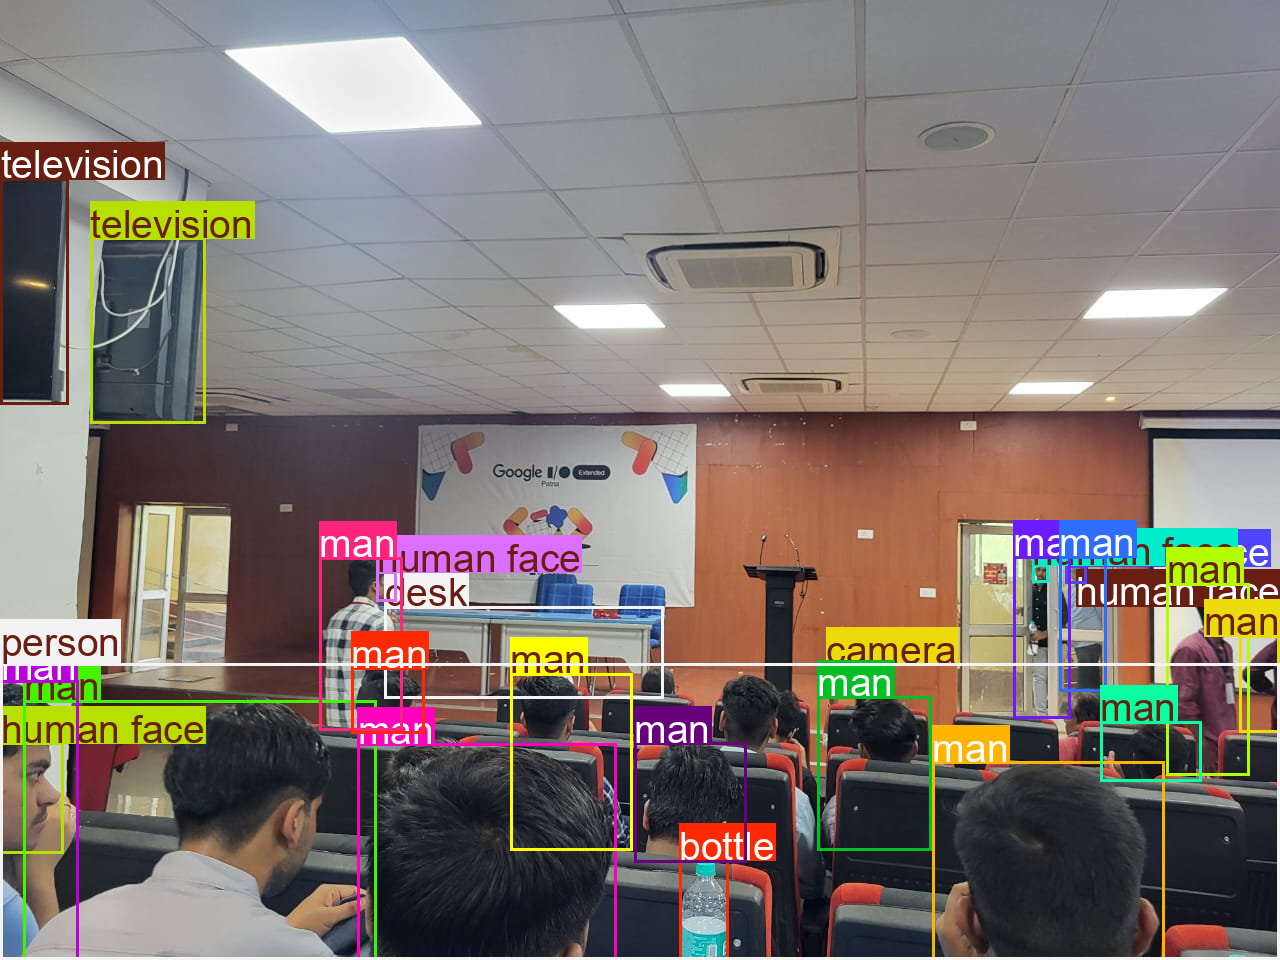

In [53]:
"""
# Result format 😀
{
    "<OD>": {
        "bboxes": [[x1, y1, x2, y2], ...],
        "labels": ["label1", "label2", ...]
    }
}
"""

task_prompt = "<OD>"
image = read_image()

results = inference(image, task_prompt)["<OD>"]

# Plot the results on an image
annotator = Annotator(image)  # initialize Ultralytics annotator

for idx, (box, label) in enumerate(zip(results["bboxes"], results["labels"])):
    annotator.box_label(box, label=label, color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output

![Object detection using florence-2](https://github.com/user-attachments/assets/6bf6820b-8eb5-44f2-a626-64d76c92b981)

### Object detection (video)

You can also run videos through the Florence-2 model—yep, not just images. Frame by frame.

In [55]:
"""
# Result format 😀
{
    "<OD>": {
        "bboxes": [[x1, y1, x2, y2], ...],
        "labels": ["label1", "label2", ...]
    }
}
"""
import random

labels_dict = {}
task_prompt = "<OD>"

# Download and read the demo video file
# safe_download("https://github.com/ultralytics/assets/releases/download/v0.0.0/solutions_ci_demo.mp4")
cap = cv2.VideoCapture("/content/sample_data/solutions_ci_demo.mp4")

# Video writer
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
video_writer = cv2.VideoWriter("florence-2-output.avi", cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))

# Process video
while cap.isOpened():
    success, frame = cap.read()

    if success:
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        results = inference(image, task_prompt=task_prompt)[task_prompt]

        annotator = Annotator(image, line_width=6)  # initialize annotator

        for idx, (box, label) in enumerate(zip(results["bboxes"], results["labels"])):
            x1, y1, x2, y2 = box
            if x1 > x2:
                x1, x2 = x2, x1  # Swap x-coordinates if needed
            if y1 > y2:
                y1, y2 = y2, y1  # Swap y-coordinates if needed

            # Add label color
            if label not in labels_dict:
                color = colors(random.randint(1, 20))
                labels_dict[label] = color
            else:
                color = labels_dict[label]

            # Box plotting
            annotator.box_label([x1, y1, x2, y2], label=label, color=color)

        video_writer.write(cv2.cvtColor(annotator.result(), cv2.COLOR_BGR2RGB))
    else:
        break

# Release video capture and writer
cap.release()
video_writer.release()

KeyboardInterrupt: 

### Caption  

Generate captions for an input image without providing a custom prompt. By default, Caption feature in Florence-2 provides three levels of captions:

- `CAPTION`
- `DETAILED_CAPTION`
- `MORE_DETAILED_CAPTION`.  

🚀 `CAPTION` is generally more accurate, while `DETAILED_CAPTION` and `MORE_DETAILED_CAPTION` may not always be as precise.

In [56]:
task_prompt = "<CAPTION>"
inference(image, task_prompt)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 12.12 MiB is free. Process 3894 has 14.73 GiB memory in use. Of the allocated memory 14.16 GiB is allocated by PyTorch, and 450.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
task_prompt = "<DETAILED_CAPTION>"
inference(image, task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a group of people walking down a street next to a bus, with a building in the background featuring windows, railings, doors, and balconies, as well as trees and a sign board. The people are wearing different types of clothing, suggesting that the image is related to the use of augmented reality in Madrid.'}

In [ ]:
task_prompt = "<MORE_DETAILED_CAPTION>"
inference(image, task_prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a blue and white bus on a street with a group of people walking on the sidewalk in front of it. The bus has the words "man" and "trousers" written on it, along with a logo of a leaf and the text "cero emisiones" which translates to "man". There are also several labels on the bus, including "coat", "trouser", "footwear", "wheel", and "focwear". The people in the image appear to be of different ages and genders, and they are dressed in casual clothing. The street is lined with buildings and there is a tree on the left side of the image.'}

### Dense region caption

For more precise results, such as specific locations, cities, places, or object types, we can use dense region captioning. Instead of a general caption like `"a bus in an image,"` we can obtain a more detailed description, such as `"an electric bus in Madrid, Spain."`


In [57]:
"""
# Result format 😀
{
    "<DENSE_REGION_CAPTION>": {
        "bboxes": [[x1, y1, x2, y2], ...],
        "labels": ["label1", "label2", ...]
    }
}
"""

task_prompt = "<DENSE_REGION_CAPTION>"
image = read_image()

results = inference(image, task_prompt)["<DENSE_REGION_CAPTION>"]

# Plot the results on an image
annotator = Annotator(image)  # initialize Ultralytics annotator

for idx, (box, label) in enumerate(zip(results["bboxes"], results["labels"])):
    annotator.box_label(box, label=label, color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output

OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 12.12 MiB is free. Process 3894 has 14.73 GiB memory in use. Of the allocated memory 14.16 GiB is allocated by PyTorch, and 446.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

![Dense region captioning using florence-2](https://github.com/user-attachments/assets/b10efb49-f8a8-46f6-aa62-36782d824d9f)

### Region proposal

Region proposal refers to the process of identifying areas in an image that are likely to contain objects. It helps in object detection by suggesting potential object locations before classification and bounding box refinement.

In [58]:
"""
# Results format 🎉
{
    "<REGION_PROPOSAL>": {
        "bboxes": [[x1, y1, x2, y2], ...],
        "labels": ["label1", "label2", ...]
    }
}
"""

task_prompt = "<REGION_PROPOSAL>"
image = read_image()

results = inference(image, task_prompt)["<REGION_PROPOSAL>"]

# Plot the results on an image
annotator = Annotator(image)  # initialize Ultralytics annotator
for idx, box in enumerate(results["bboxes"]):
    x1, y1, x2, y2 = box
    if x1 > x2:
        x1, x2 = x2, x1  # Swap x-coordinates if needed
    if y1 > y2:
        y1, y2 = y2, y1  # Swap y-coordinates if needed

    # Update the bounding box correctly
    annotator.box_label([x1, y1, x2, y2], color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output

OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 12.12 MiB is free. Process 3894 has 14.73 GiB memory in use. Of the allocated memory 14.17 GiB is allocated by PyTorch, and 441.99 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

![Region proposal using florence-2](https://github.com/user-attachments/assets/b0e3e004-f9f6-4937-9ea9-431be56e1476)

## Execute pre-defined tasks that require additional inputs

Here, we can provide a custom prompt to generate precise results tailored to specific requirements.

### Phrase grounding

We can also extract specific results i.e. `a bus` or `Madrid bus` by passing additional text_input.

In [ ]:
"""
# Results format: 🚀
{
    "<CAPTION_TO_PHRASE_GROUNDING>": {
        "bboxes": [[x1, y1, x2, y2], ...],
        "labels": ["label1", "label2", ...]
    }
}
"""

task_prompt = "<CAPTION_TO_PHRASE_GROUNDING>"
image = read_image()

results = inference(image, task_prompt, text_input="a madrid bus, glasses")["<CAPTION_TO_PHRASE_GROUNDING>"]

# Plot the results on an image
annotator = Annotator(image)  # initialize Ultralytics annotator

for idx, (box, label) in enumerate(zip(results["bboxes"], results["labels"])):
    annotator.box_label(box, label=label, color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output

![Captions to phrase grouding using florence-2](https://github.com/user-attachments/assets/4c2dee5b-afd2-4d99-bc8d-bf24b93937fb)

### Referring to expression segmentation

We can use Florence-2 for segmentation based on specific expression.

In [59]:
"""
# Results format 😃

# one object is represented by a list of polygons. each polygon is [x1, y1, x2, y2, ..., xn, yn]
{
    "<REFERRING_EXPRESSION_SEGMENTATION>": {
        {'Polygons': [[[polygon]], ...],
        "labels": ["label1", "label2", ...]
    }
}
"""

task_prompt = "<REFERRING_EXPRESSION_SEGMENTATION>"
image = read_image()

results = inference(image, task_prompt, text_input="person with black coat showoff")[
    "<REFERRING_EXPRESSION_SEGMENTATION>"
]

# segmentation mask function required the numpy array image, not PIL based image.
annotator = SolutionAnnotator(np.array(image, dtype=np.uint8))

for idx, (polygons, label) in enumerate(zip(results["polygons"], results["labels"])):
    for polygon in polygons:
        polygon = np.array(polygon).reshape(-1, 2)

        if len(polygon) < 3:
            print("Invalid polygon:", polygon)
            continue

        annotator.segmentation_mask(polygon, label=label, mask_color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output

OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 12.12 MiB is free. Process 3894 has 14.73 GiB memory in use. Of the allocated memory 14.17 GiB is allocated by PyTorch, and 437.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

![Captions to phrase grouding using florence-2](https://github.com/user-attachments/assets/d70a8c3a-709d-43cf-863a-e2c16036424e)

### Region to segmentation

Here, we can segment a specific area by providing its coordinates.

`<loc_x1>\<loc_y1>\<loc_x2>\<loc_y2>, [x1, y1, x2, y2] is the normalized coordinates in [0, 999].`

In [ ]:
task_prompt = "<REGION_TO_SEGMENTATION>"
image = read_image()

results = inference(
    image, task_prompt, text_input="[3.8328723907470703, 229.35601806640625,796.2098999023438, 728.4313354492188]"
)["<REGION_TO_SEGMENTATION>"]

# segmentation mask function required the numpy array image, not PIL based image.
annotator = SolutionAnnotator(np.array(image, dtype=np.uint8))

for idx, (polygons, label) in enumerate(zip(results["polygons"], results["labels"])):
    for _polygon in polygons:
        _polygon = np.array(_polygon).reshape(-1, 2)

        if len(_polygon) < 3:
            print("Invalid polygon:", _polygon)
            continue

        annotator.segmentation_mask(_polygon, label=label, mask_color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output

![Region to segmentation using florence-2](https://github.com/user-attachments/assets/0dc7aff0-a688-4a08-a895-ba05678a2dec)

### Open vocabulary detection

It enables models to detect both objects and text (OCR) without being limited to predefined categories, making it highly adaptable for real-world applications like retail, navigation, and document analysis.

In [ ]:
"""
# Results format 😀

{ '<OPEN_VOCABULARY_DETECTION>':

      {'bboxes': [[x1, y1, x2, y2], [x1, y1, x2, y2], ...]],
      'bboxes_labels': ['label_1', 'label_2', ..],
      'polygons': [[[x1, y1, x2, y2, ..., xn, yn], [x1, y1, ..., xn, yn]], ...],
      'polygons_labels': ['label_1', 'label_2', ...]
      }
}
"""

task_prompt = "<OPEN_VOCABULARY_DETECTION>"
image = read_image()

results = inference(image, task_prompt, text_input="trees")["<OPEN_VOCABULARY_DETECTION>"]

# segmentation mask function required the numpy array image, not PIL based image.
annotator = Annotator(image)

for idx, (box, label) in enumerate(zip(results["bboxes"], results["bboxes_labels"])):
    annotator.box_label(box, color=colors(idx, True), label=label)

Image.fromarray(annotator.result())  # display the output

![Open vocabulary detection using florence-2](https://github.com/user-attachments/assets/6368ac07-6083-4762-9020-b516be328d2d)

## OCR related tasks

Florence 2 can also be utilized for OCR-related tasks.

In [ ]:
# Download and read the sample image for OCR
# Sample images: ocr_img_for_florence_2_notebook.jpg, ocr_img_2_for_florence_2_notebook.jpg
image = read_image(filename="ocr_img_1_for_florence_2_notebook.jpg")

task_prompt = "<OCR_WITH_REGION>"
results = inference(image, task_prompt)["<OCR_WITH_REGION>"]

# segmentation mask function required the numpy array image, not PIL based image.
annotator = Annotator(image, line_width=2)

for idx, (box, label) in enumerate(zip(results["quad_boxes"], results["labels"])):
    box = box[:4]
    x1, y1, x2, y2 = box
    if x1 > x2:
        x1, x2 = x2, x1  # Swap x-coordinates if needed
    if y1 > y2:
        y1, y2 = y2, y1  # Swap y-coordinates if needed

    # Update the bounding box correctly
    annotator.box_label([x1, y1, x2, y2], label=label, color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output

![Open vocabulary detection using florence-2](https://github.com/user-attachments/assets/1208bf8d-989a-4260-841b-f126ff69f061)

## Additional Resources  

✅ Florence-2 research paper: [here](https://arxiv.org/abs/2311.06242)  
✅ Ultralytics Annotator: [here](https://docs.ultralytics.com/reference/utils/plotting/)

🌟 Explore the [Ultralytics Notebooks](https://github.com/ultralytics/notebooks/) and give them a star to boost your AI journey! 🚀

Built with 💙 by [Ultralytics](https://ultralytics.com/)  